# PREPROCESSING --version 002

- date split into summer & running date
- PCA on all features


----


In [1]:
version_ID = '003'
version_note = '_full_pca_'

In [23]:
import numpy as np
import pandas as pd
import sklearn 
from sklearn.model_selection import train_test_split
from random import shuffle
import os
from os import path
import time
import warnings
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

-----

### Load datasets

In [3]:
#import data
X = pd.read_csv('../../data/raw/train_data.csv.zip')
summer_weeks = pd.read_csv('../../data/additional/summer_intensity.csv')

#split dataset into train and test
X_train_input, X_test_input = train_test_split(X, test_size=0.2, random_state=42, shuffle=True)
print(X_train_input.shape, X_test_input.shape)

(300587, 246) (75147, 246)


In [4]:
# import helper data
summer_weeks = pd.read_csv('../../data/additional/summer_intensity.csv')

### Prepare columns & NN

In [5]:
#get parameters for normalization --> avoid data leekage
norm_paras = X_train_input.agg(['mean', 'std', 'median'])

# reduce expanded features
collapse = []
coll_patt = []

for p in coll_patt:
    pt = re.compile(p)
    collapse += [[c for c in X_train_input.columns if pt.match(c)]]

/tmp/ipykernel_10141/264238592.py:2: FutureWarning: ['startdate', 'climateregions__climateregion'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  norm_paras = X_train_input.agg(['mean', 'std', 'median'])


In [6]:
#get drop columns
drops = ['startdate']
patterns = []

for p in patterns:
    p = re.compile(p)
    drops += [k for k in X_train_input.columns if bool(p.match(k))]
#print(len(drops), '\n', drops)

### Preprocessing pipeline

In [50]:
def preprocess(X, norm_paras=norm_paras, pca=None):

    warnings.filterwarnings("ignore")
    length = X.shape[0]
    target = 'contest-tmp2m-14d__tmp2m'

    # extract y
    if target in X.columns.values:
        y = X[target].to_numpy()
        X = X.drop(labels=target, axis=1)
    else:    y = None
    
    
    ############# TRANSFORMATION ###############
    print("transforming cols...")
    
    # collapse expanded features
    for i in range(len(coll_patt)):
        name = coll_patt[i].strip('.+-')
        X[f'{name}_mn'] = X[collapse[i]].mean(axis=1)
        X[f'{name}_std'] = X[collapse[i]].std(axis=1)
       
    # normalize numerical variables and fill missing values
    numerical = norm_paras.columns[norm_paras.columns != target]
    for col in numerical:
        X[col].fillna(norm_paras[col]['median'], inplace=True)
        X[col] = (X[col] - norm_paras[col]['mean']) / norm_paras[col]['std']
        X[col] = np.float32(X[col])
    
    # convert date (to time progress & summer intensity)
    dates = pd.to_datetime(X.startdate)
    # 2014-2016 are translated to [0,1]
    X['time_prog'] = [(((d.year - 2014) * 364 + d.month * 30 + d.day) - 9 * 30) / (2 * 364) for d in dates] 
    X['summer'] = [summer_weeks.loc[summer_weeks.week == d.week].values[0][1] for d in dates] # 0: winter, 1: summer
    
    # drop columns
    X = X.drop(labels=drops, axis=1).copy()
    
    # one-hot-encode categorical variables
    X = pd.get_dummies(X, columns=['climateregions__climateregion'])
    
    
    ################# PCA ####################

    n = 100
    print(f"performing PCA from {X.shape[1]} features to {n} dimensions ...")
    
    if pca is None:
        pca = PCA(n_components=n).fit(X)
        
        n_all = X.shape[1]
        pca_all = PCA(n_components=n_all).fit(X)
        plt.bar(range(n_all), pca_all.explained_variance_ratio_,
                alpha=0.5,
                align='center')
        plt.step(range(n_all), np.cumsum(pca_all.explained_variance_ratio_),
                where='mid',
                color='red')
        plt.vlines(n, 0, 1, linestyles='dashed', colors='green')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal Components')
        plt.show()
        
    X_final = pca.transform(X)


    ################# INFO ##################

    print("PREPROCESSING result:")
    print(f"  Shape X: {X_final.shape}  || Shape Y: {y.shape if y is not None else None}")

    return X_final, y, X, pca

----

### PREPROCESSING

transforming cols...
performing PCA from 260 features to 100 dimensions ...


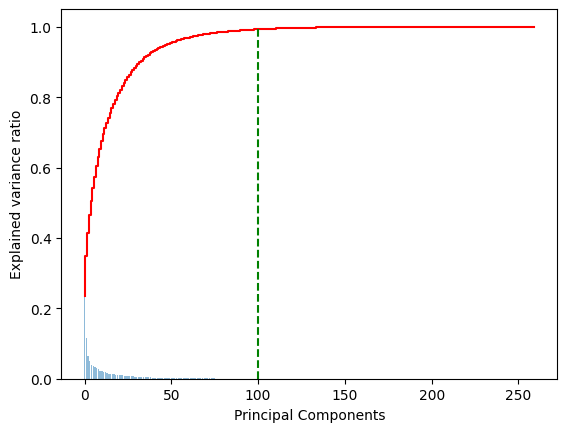

PREPROCESSING result:
  Shape X: (300587, 100)  || Shape Y: (300587,)


In [52]:
# preprocess train.csv
X_train, y_train, X_df, pca = preprocess(X_train_input)

In [53]:
X_test, y_test, _, _ = preprocess(X_test_input, pca=pca)

transforming cols...
performing PCA from 260 features to 100 dimensions ...
PREPROCESSING result:
  Shape X: (75147, 100)  || Shape Y: (75147,)


In [54]:
# preprocess test.csv
X_prediction = pd.read_csv('../../data/raw/test_data.csv.zip')
X_prediction, _, _, _ = preprocess(X_prediction, pca=pca)

transforming cols...
performing PCA from 260 features to 100 dimensions ...
PREPROCESSING result:
  Shape X: (31354, 100)  || Shape Y: None


---------------

# Save dataset 
--version

In [55]:
# prepare folder and info file for dataset versions

timestamp = time.strftime("on %Y_%m_%d at %H_%M")

overview = pd.read_csv('../../data/preprocessed/dataset_overview.csv')

if not os.path.exists(f'../../data/preprocessed/{version_ID}'):
        os.mkdir(f'../../data/preprocessed/{version_ID}')

#append to overview logs
overview = overview.append({'version_ID': version_ID, 'version_note': version_note, 'timestamp': timestamp}, 
                                ignore_index=True)
overview = overview[{'version_ID', 'version_note', 'timestamp'}]
overview.drop_duplicates(inplace=True)
overview.to_csv('../../data/preprocessed/dataset_overview.csv')

# save preprocessed data
np.save(f'../../data/preprocessed/{version_ID}/X_train.npy', X_train)
np.save(f'../../data/preprocessed/{version_ID}/X_test.npy', X_test)
np.save(f'../../data/preprocessed/{version_ID}/y_train.npy', y_train)
np.save(f'../../data/preprocessed/{version_ID}/y_test.npy', y_test)
np.save(f'../../data/preprocessed/{version_ID}/X_predict.npy', X_prediction)
X_df.describe().to_csv(f'../../data/preprocessed/{version_ID}/columns.csv')

In [56]:
# see overview of existant datasets

overview = pd.read_csv('../../data/preprocessed/dataset_overview.csv')
overview

,Unnamed: 0,version_note,version_ID,timestamp
0,0,first,first,on 2023_01_06 at 13_15
1,1,first,first,on 2023_01_06 at 13_35
2,2,first,first,on 2023_01_06 at 15_27
3,3,first,first,on 2023_01_06 at 15_47
4,4,_coldrop_datesplit_,001,on 2023_01_31 at 16_54
5,5,_pca_,002,on 2023_02_24 at 18_02
6,6,_full_pca_,003,on 2023_02_25 at 11_10
7,7,_full_pca_,003,on 2023_02_25 at 11_14
8,8,_full_pca_,003,on 2023_02_25 at 12_17


In [13]:
############# use to create new overview-version and DELETE OLD VERSIONS #############

#overview = pd.DataFrame(columns=['version_ID', 'version_note', 'timestamp'])
#overview.to_csv('../data/preprocessed/dataset_overview.csv')